In [11]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using %s for computation" % device)

Using cuda for computation


In [13]:
def get_dataloader(batch_size, image_size, data_dir=r'C:\Users\nikhi\Music\s6-pro\Maths\nf'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor()])
    # TODO: Implement function and return a dataloader
    dataset = datasets.ImageFolder(data_dir,transform = transform)
    
    dataloader = torch.utils.data.DataLoader(dataset = dataset,batch_size = batch_size,shuffle = True)
    return dataloader

In [14]:
# Define function hyperparameters
batch_size = 256
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

C:\Users\nikhi\AppData\Local\Temp/ipykernel_2732/1073742529.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


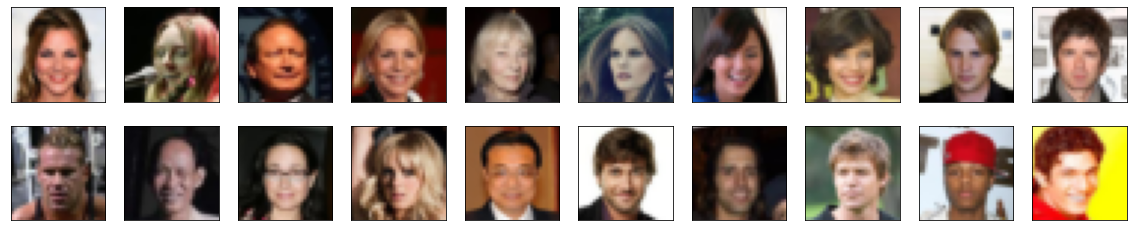

In [16]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [17]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min) + min
    return x

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.9765)


Define the Model


A GAN is comprised of two adversarial networks, a discriminator and a generator.

Discriminator


Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with normalization. You are also allowed to create any helper functions that may be useful.



In [22]:
import torch.nn as nn
import torch.nn.functional as F
import problem_unittests as tests

In [23]:
def conv(input_c,output,kernel_size,stride = 2,padding  = 1, batch_norm = True):
    layers =[]
    con = nn.Conv2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(con)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(output))
    
    return nn.Sequential(*layers)

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False) #16
        self.layer_2 = conv(conv_dim,conv_dim*2,4) #8
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4) #4
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.layer_1(x))
        x = F.leaky_relu(self.layer_2(x))
        x = F.leaky_relu(self.layer_3(x))
        x = x.view(-1,self.conv_dim*4*4*4)
        x = self.fc(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


Generator

The generator should upsample an input and generate a new image of the same size as our training data 32x32x3. This should be mostly transpose convolutional layers with normalization applied to the outputs.

In [24]:
def deconv(input_c,output,kernel_size,stride = 2, padding =1, batch_norm = True):
    layers = []
    decon = nn.ConvTranspose2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(decon)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(output))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size,conv_dim*8*2*2)
        self.layer_1 = deconv(conv_dim*8,conv_dim*4,4)
        self.layer_2 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_3 = deconv(conv_dim*2,conv_dim,4)
        self.layer_4 = deconv(conv_dim,3,4,batch_norm = False)
        # complete init function
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1,self.conv_dim*8,2,2) #(batch_size,depth,width,height)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = torch.tanh(self.layer_4(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


In [25]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m,'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        
        m.weight.data.normal_(0.0,0.02)
    
        if hasattr(m,'bias') and m.bias is not None:
            m.bias.data.zero_()

Build complete network

In [26]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [27]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (layer_1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding

In [28]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [29]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion =  nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [30]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr = .0002, betas = [0.5,0.999])
g_optimizer = optim.Adam(G.parameters(),lr = .0002, betas = [0.5,0.999])

In [32]:
import pickle as pkl

In [31]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake ima.ges
            d_optimizer.zero_grad()
            d_out_real = D(real_images)
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            d_loss = real_loss(d_out_real) + fake_loss(D(G(z)))
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            G.train()
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            g_loss = real_loss(D(G(z)))
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [33]:
# set number of epochs 
n_epochs = 40


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 2.1689 | g_loss: 1.4628
Epoch [    1/   40] | d_loss: 0.1470 | g_loss: 5.8394
Epoch [    1/   40] | d_loss: 0.1988 | g_loss: 4.5727
Epoch [    1/   40] | d_loss: 0.6971 | g_loss: 4.0196
Epoch [    1/   40] | d_loss: 0.7112 | g_loss: 2.0555
Epoch [    1/   40] | d_loss: 0.6781 | g_loss: 2.3572
Epoch [    1/   40] | d_loss: 0.7870 | g_loss: 3.2297
Epoch [    1/   40] | d_loss: 0.7736 | g_loss: 1.7994
Epoch [    1/   40] | d_loss: 0.7461 | g_loss: 2.9201
Epoch [    2/   40] | d_loss: 1.2871 | g_loss: 5.1254
Epoch [    2/   40] | d_loss: 0.8183 | g_loss: 2.0732
Epoch [    2/   40] | d_loss: 0.7629 | g_loss: 2.0996
Epoch [    2/   40] | d_loss: 0.8301 | g_loss: 2.3218
Epoch [    2/   40] | d_loss: 0.6587 | g_loss: 2.0325
Epoch [    2/   40] | d_loss: 0.9254 | g_loss: 1.1126
Epoch [    2/   40] | d_loss: 0.7897 | g_loss: 2.0784
Epoch [    2/   40] | d_loss: 0.9080 | g_loss: 1.4967
Epoch [    2/   40] | d_loss: 1.6596 | g_loss: 0.3391
Epoch [    3/   40] | d_loss

Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.



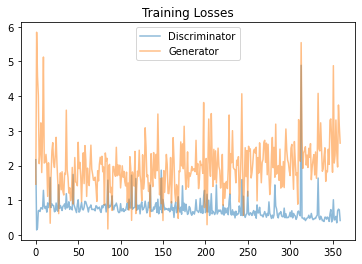

In [34]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()


In [35]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255/2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [36]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

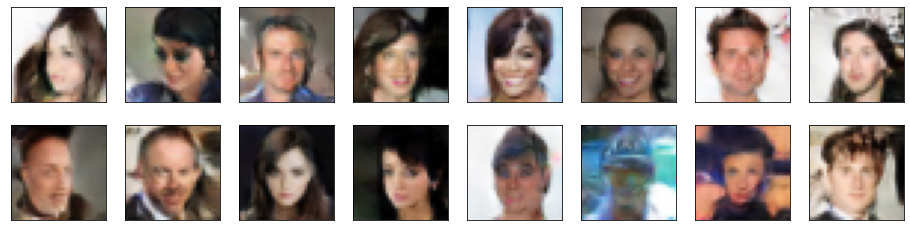

In [37]:
_ = view_samples(-1, samples)